<a href="https://colab.research.google.com/github/Zonner93/covid_neural_network_CNN/blob/main/covid_neural_network_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!ls

sample_data


In [2]:
!rm -rf sample_data

### Importowanie bibliotek

In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shutil
import plotly.graph_objects as go
from sklearn.metrics import confusion_matrix, classification_report

from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import TensorBoard

np.set_printoptions(precision=6, suppress=True)

### Konfiguracja Kaggla

In [4]:
! pip install -q kaggle

In [6]:
from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"jacekdarkowski","key":"65e484c4e301bab1f718ba8d1e0ebe85"}'}

In [7]:
! mkdir ~/.kaggle

In [8]:
! cp kaggle.json ~/.kaggle/

In [9]:
! chmod 600 ~/.kaggle/kaggle.json

In [10]:
! kaggle datasets list

ref                                                                title                                              size  lastUpdated          downloadCount  voteCount  usabilityRating  
-----------------------------------------------------------------  ------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
arnabchaki/data-science-salaries-2023                              Data Science Salaries 2023 💸                       25KB  2023-04-13 09:55:16           9380        249  1.0              
asahu40/walmart-data-analysis-and-forcasting                       Walmart Data Analysis and Forcasting              122KB  2023-04-26 07:07:03           1169         31  1.0              
ahmedshahriarsakib/usa-real-estate-dataset                         USA Real Estate Dataset                             1MB  2023-04-30 03:51:36            886         27  1.0              
iammustafatz/diabetes-prediction-dataset               

In [14]:
!kaggle datasets download -d tawsifurrahman/covid19-radiography-database

 98% 764M/778M [00:05<00:00, 175MB/s]
100% 778M/778M [00:05<00:00, 140MB/s]


In [15]:
!unzip -q covid19-radiography-database.zip

In [17]:
!rm -rf covid19-radiography-database.zip

In [18]:
!ls

COVID-19_Radiography_Dataset  kaggle.json


### Przygotowanie zbiorów: treningowego, walidacyjnego oraz testowego

In [25]:
BASE_DIR = './COVID-19_Radiography_Dataset'
raw_number_of_files = {}
classes = ['COVID/images', 'Lung_Opacity/images', 'Normal/images', 'Viral Pneumonia/images']
for dir in classes:
    raw_number_of_files[dir] = len(os.listdir(os.path.join(BASE_DIR, dir)))

raw_number_of_files.items()

dict_items([('COVID/images', 3616), ('Lung_Opacity/images', 6012), ('Normal/images', 10192), ('Viral Pneumonia/images', 1345)])

In [26]:
DATA_DIR = './images'

if not os.path.exists(DATA_DIR):
    os.mkdir(DATA_DIR)

train_dir = os.path.join(DATA_DIR, 'train')  # ścieżka do katalogu danych trenujących
valid_dir = os.path.join(DATA_DIR, 'valid')  # ścieżka do katalogu danych walidacyjnych
test_dir = os.path.join(DATA_DIR, 'test')  # ścieżka do katalogu danych testujących

train_covid_dir = os.path.join(train_dir, 'covid')
train_lung_opacity_dir = os.path.join(train_dir, 'lung_opacity')
train_normal_dir = os.path.join(train_dir, 'normal')
train_viral_pneumonia_dir = os.path.join(train_dir, 'viral_pneumonia')

valid_covid_dir = os.path.join(valid_dir, 'covid')
valid_lung_opacity_dir = os.path.join(valid_dir, 'lung_opacity')
valid_normal_dir = os.path.join(valid_dir, 'normal')
valid_viral_pneumonia_dir = os.path.join(valid_dir, 'viral_pneumonia')

test_covid_dir = os.path.join(test_dir, 'covid')
test_lung_opacity_dir = os.path.join(test_dir, 'lung_opacity')
test_normal_dir = os.path.join(test_dir, 'normal')
test_viral_pneumonia_dir = os.path.join(test_dir, 'viral_pneumonia')

for directory in (train_dir, valid_dir, test_dir):
    if not os.path.exists(directory):
        os.mkdir(directory)

dirs = [train_covid_dir, train_lung_opacity_dir, train_normal_dir, train_viral_pneumonia_dir,
        valid_covid_dir, valid_lung_opacity_dir, valid_normal_dir, valid_viral_pneumonia_dir,
        test_covid_dir, test_lung_opacity_dir, test_normal_dir, test_viral_pneumonia_dir]

for dir in dirs:
    if not os.path.exists(dir):
        os.mkdir(dir)

In [27]:
covid_file_names = os.listdir(os.path.join(BASE_DIR, 'COVID/images'))
lung_opacity_file_names = os.listdir(os.path.join(BASE_DIR, 'Lung_Opacity/images'))
normal_file_names = os.listdir(os.path.join(BASE_DIR, 'Normal/images'))
viral_pneumonia_file_names = os.listdir(os.path.join(BASE_DIR, 'Viral Pneumonia/images'))

covid_file_names = [fname for fname in covid_file_names if fname.split('.')[1].lower() in ['jpg', 'png', 'jpeg']]
lung_opacity_file_names = [fname for fname in lung_opacity_file_names if fname.split('.')[1].lower() in ['jpg', 'png', 'jpeg']]
normal_file_names = [fname for fname in normal_file_names if fname.split('.')[1].lower() in ['jpg', 'png', 'jpeg']]
viral_pneumonia_file_names = [fname for fname in viral_pneumonia_file_names if fname.split('.')[1].lower() in ['jpg', 'png', 'jpeg']]

In [28]:
size = min(len(covid_file_names), len(lung_opacity_file_names), len(normal_file_names), len(viral_pneumonia_file_names))

train_size = int(np.floor(0.7 * size))
valid_size = int(np.floor(0.2 * size))
test_size = size - train_size - valid_size

train_idx = train_size
valid_idx = train_size + valid_size
test_idx = train_size + valid_size + test_size

In [34]:
for i, file_name in enumerate(covid_file_names):
    if i <= train_idx:
        src = os.path.join(BASE_DIR, 'COVID/images', file_name)
        dst = os.path.join(train_covid_dir, file_name)
        shutil.copyfile(src, dst)
    elif train_idx < i <= valid_idx:
        src = os.path.join(BASE_DIR, 'COVID/images', file_name)
        dst = os.path.join(valid_covid_dir, file_name)
        shutil.copyfile(src, dst)
    elif valid_idx < i < test_idx:
        src = os.path.join(BASE_DIR, 'COVID/images', file_name)
        dst = os.path.join(test_covid_dir, file_name)
        shutil.copyfile(src, dst)

for i, file_name in enumerate(lung_opacity_file_names):
    if i <= train_idx:
        src = os.path.join(BASE_DIR, 'Lung_Opacity/images', file_name)
        dst = os.path.join(train_lung_opacity_dir, file_name)
        shutil.copyfile(src, dst)
    elif train_idx < i <= valid_idx:
        src = os.path.join(BASE_DIR, 'Lung_Opacity/images', file_name)
        dst = os.path.join(valid_lung_opacity_dir, file_name)
        shutil.copyfile(src, dst)
    elif valid_idx < i < test_idx:
        src = os.path.join(BASE_DIR, 'Lung_Opacity/images', file_name)
        dst = os.path.join(test_lung_opacity_dir, file_name)
        shutil.copyfile(src, dst)

for i, file_name in enumerate(normal_file_names):
    if i <= train_idx:
        src = os.path.join(BASE_DIR, 'Normal/images', file_name)
        dst = os.path.join(train_normal_dir, file_name)
        shutil.copyfile(src, dst)
    elif train_idx < i <= valid_idx:
        src = os.path.join(BASE_DIR, 'Normal/images', file_name)
        dst = os.path.join(valid_normal_dir, file_name)
        shutil.copyfile(src, dst)
    elif valid_idx < i < test_idx:
        src = os.path.join(BASE_DIR, 'Normal/images', file_name)
        dst = os.path.join(test_normal_dir, file_name)
        shutil.copyfile(src, dst)

for i, file_name in enumerate(viral_pneumonia_file_names):
    if i <= train_idx:
        src = os.path.join(BASE_DIR, 'Viral Pneumonia/images', file_name)
        dst = os.path.join(train_viral_pneumonia_dir, file_name)
        shutil.copyfile(src, dst)
    elif train_idx < i <= valid_idx:
        src = os.path.join(BASE_DIR, 'Viral Pneumonia/images', file_name)
        dst = os.path.join(valid_viral_pneumonia_dir, file_name)
        shutil.copyfile(src, dst)
    elif valid_idx < i < test_idx:
        src = os.path.join(BASE_DIR, 'Viral Pneumonia/images', file_name)
        dst = os.path.join(test_viral_pneumonia_dir, file_name)
        shutil.copyfile(src, dst)

print('covid - zbiór treningowy', len(os.listdir(train_covid_dir)))
print('covid - zbiór walidacyjny', len(os.listdir(valid_covid_dir)))
print('covid - zbiór testowy', len(os.listdir(test_covid_dir)))

print('lung_opacity - zbiór treningowy', len(os.listdir(train_lung_opacity_dir)))
print('lung_opacity - zbiór walidacyjny', len(os.listdir(valid_lung_opacity_dir)))
print('lung_opacity - zbiór testowy', len(os.listdir(test_lung_opacity_dir)))

print('normal - zbiór treningowy', len(os.listdir(train_normal_dir)))
print('normal - zbiór walidacyjny', len(os.listdir(valid_normal_dir)))
print('normal - zbiór testowy', len(os.listdir(test_normal_dir)))

print('viral_pneumonia - zbiór treningowy', len(os.listdir(train_viral_pneumonia_dir)))
print('viral_pneumonia - zbiór walidacyjny', len(os.listdir(valid_viral_pneumonia_dir)))
print('viral_pneumonia - zbiór testowy', len(os.listdir(test_viral_pneumonia_dir)))

covid - zbiór treningowy 942
covid - zbiór walidacyjny 269
covid - zbiór testowy 134
lung_opacity - zbiór treningowy 942
lung_opacity - zbiór walidacyjny 269
lung_opacity - zbiór testowy 134
normal - zbiór treningowy 942
normal - zbiór walidacyjny 269
normal - zbiór testowy 134
viral_pneumonia - zbiór treningowy 942
viral_pneumonia - zbiór walidacyjny 269
viral_pneumonia - zbiór testowy 134


(-0.5, 298.5, 298.5, -0.5)

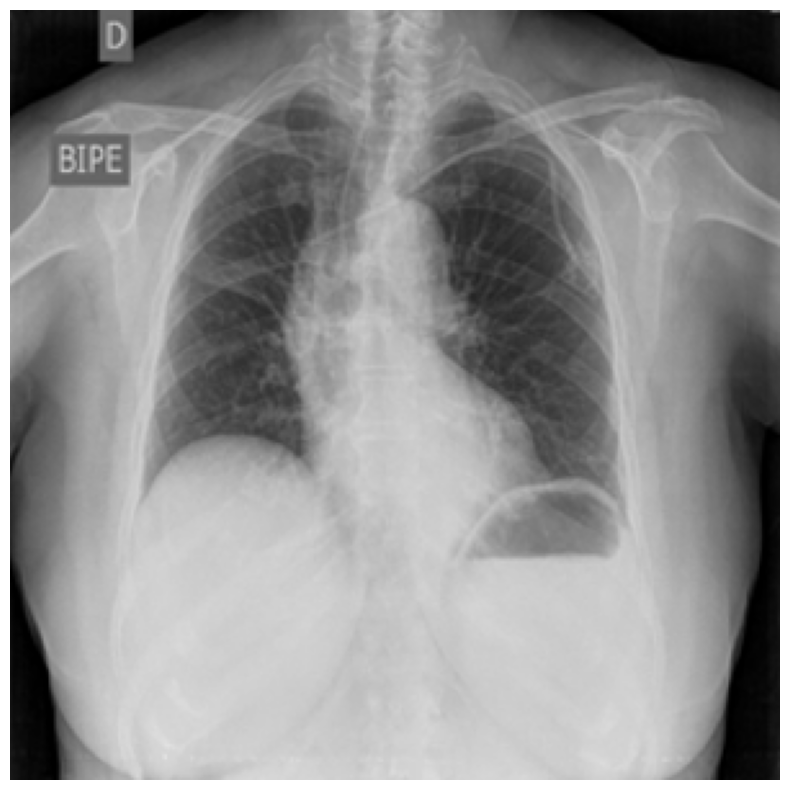

In [38]:
# @title Wybierz indeks przykładowego zdjęcia covid ze zbioru treningowego:

idx = 723  # @param {type:'slider', min:0, max:821}
names_mapping = dict(enumerate(covid_file_names))
img_path = os.path.join(train_covid_dir, names_mapping[idx])

img = image.load_img(img_path)

plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.grid(False)
plt.axis(False)

(-0.5, 298.5, 298.5, -0.5)

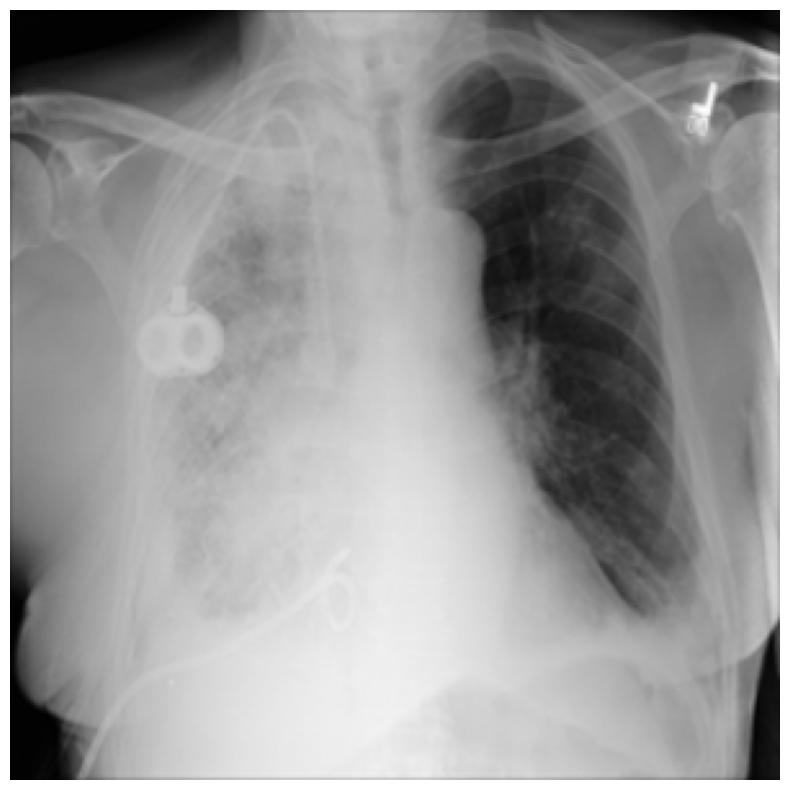

In [39]:
# @title Wybierz indeks przykładowego zdjęcia lung_opacity ze zbioru treningowego:

idx = 301  # @param {type:'slider', min:0, max:821}
names_mapping = dict(enumerate(lung_opacity_file_names))
img_path = os.path.join(train_lung_opacity_dir, names_mapping[idx])

img = image.load_img(img_path)

plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.grid(False)
plt.axis(False)

(-0.5, 298.5, 298.5, -0.5)

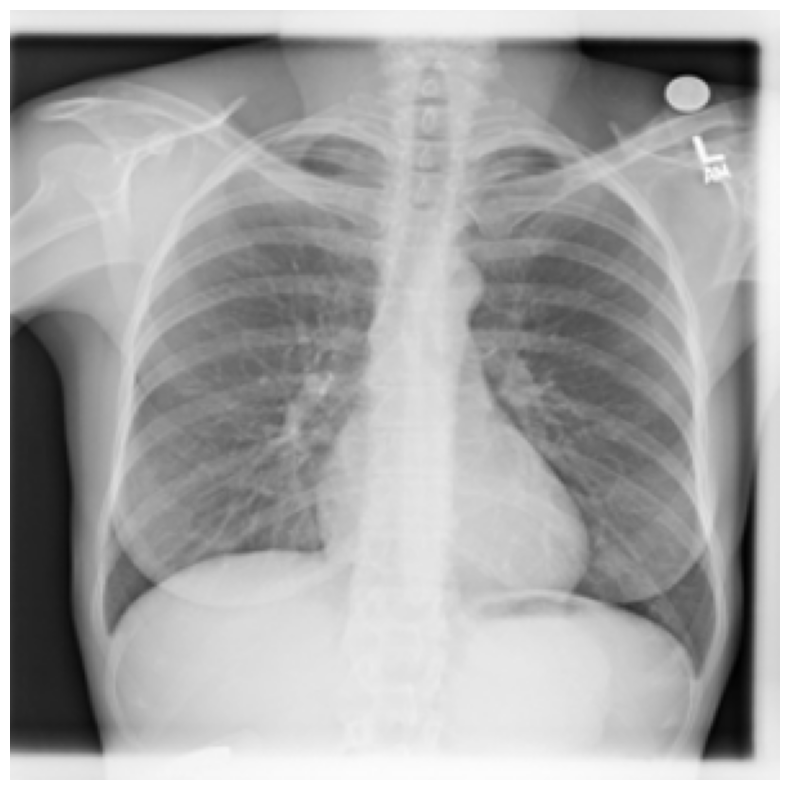

In [40]:
# @title Wybierz indeks przykładowego zdjęcia normal ze zbioru treningowego:

idx = 40  # @param {type:'slider', min:0, max:821}
names_mapping = dict(enumerate(normal_file_names))
img_path = os.path.join(train_normal_dir, names_mapping[idx])

img = image.load_img(img_path)

plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.grid(False)
plt.axis(False)

(-0.5, 298.5, 298.5, -0.5)

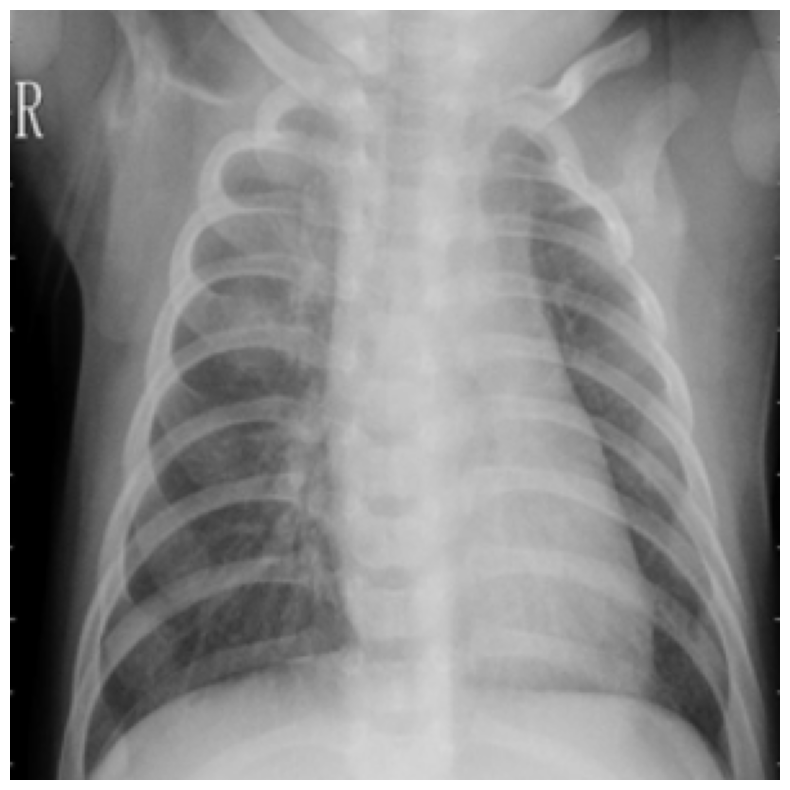

In [46]:
# @title Wybierz indeks przykładowego zdjęcia rakiety ze zbioru treningowego:

idx = 0  # @param {type:'slider', min:0, max:821}
names_mapping = dict(enumerate(viral_pneumonia_file_names))
img_path = os.path.join(train_viral_pneumonia_dir, names_mapping[idx])

img = image.load_img(img_path)

plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.grid(False)
plt.axis(False)

### Augmentacja danych

In [47]:
train_data_generator = ImageDataGenerator(
    rotation_range=40,  # zakres kąta o który losowo zostanie wykonany obrót obrazów
    rescale=1. / 255.,  # skalowanie
    width_shift_range=0.2,  # pionowe przekształcenia obrazu
    height_shift_range=0.2,  # poziome przekształcenia obrazu
    shear_range=0.2,  # zares losowego przycianania obrazu
    zoom_range=0.2,  # zakres losowego przybliżania obrazu
    horizontal_flip=True,  # losowe odbicie połowy obrazu w płaszczyźnie poziomej
    fill_mode='nearest'  # strategia wypełniania nowo utworzonych pikseli, któe mogą powstać w wyniku przekształceń
)

# przeskalowujemy wszystkie obrazy o współczynnik 1/255
valid_data_generator = ImageDataGenerator(rescale=1. / 255.)

train_generator = train_data_generator.flow_from_directory(directory=train_dir,
                                                           target_size=(150, 150),
                                                           batch_size=32,
                                                           class_mode='categorical')

valid_generator = valid_data_generator.flow_from_directory(directory=valid_dir,
                                                           target_size=(150, 150),
                                                           batch_size=32,
                                                           class_mode='categorical')

Found 3768 images belonging to 4 classes.
Found 1076 images belonging to 4 classes.


In [48]:
def display_augmented_images(directory, idx):
    """
    Funkcja zwraca wykres przykładowych obrazów uzyskanych za pomocą techniki
    augmentacji danych.
    """
    file_names = [os.path.join(directory, file_name) for file_name in os.listdir(directory)]
    img_path = file_names[idx]
    img = image.load_img(img_path, target_size=(150, 150))

    x = image.img_to_array(img)
    x = x.reshape((1,) + x.shape)

    i = 1
    plt.figure(figsize=(16, 8))
    for batch in train_data_generator.flow(x, batch_size=1):
        plt.subplot(3, 4, i)
        plt.grid(False)
        imgplot = plt.imshow(image.array_to_img(batch[0]))
        i += 1
        if i % 13 == 0:
            break

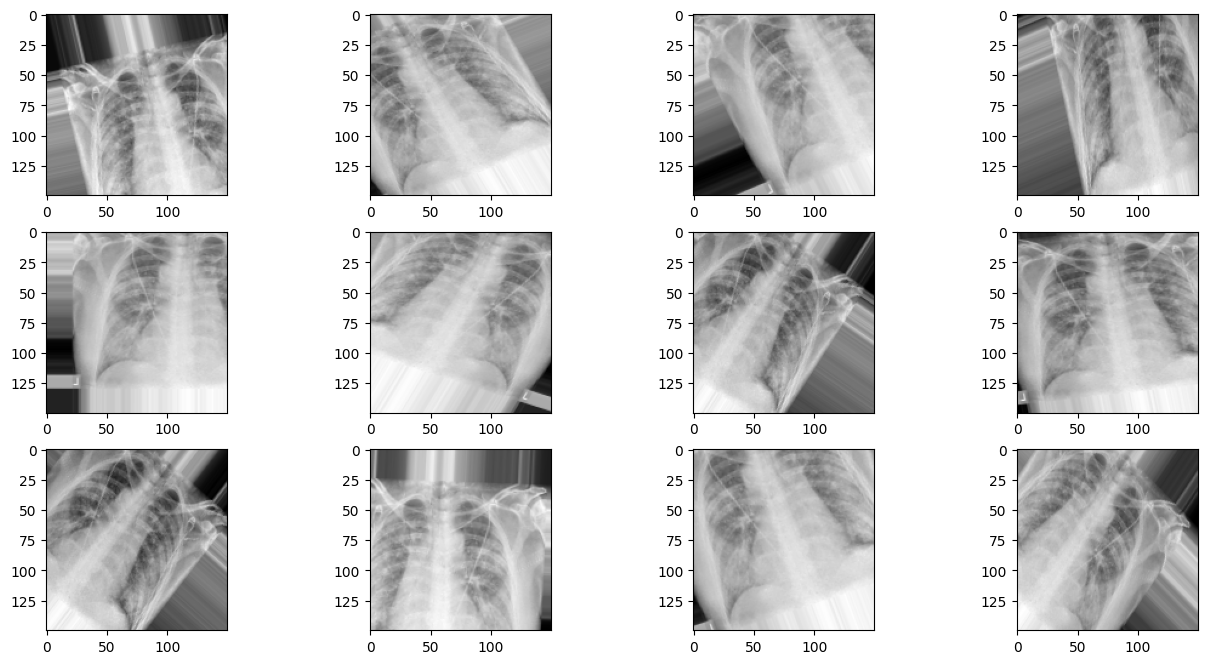

In [49]:
# @title Zbiór treningowy covid:
idx = 786  # @param {type:'slider', min:0, max:821}
display_augmented_images(train_covid_dir, idx)

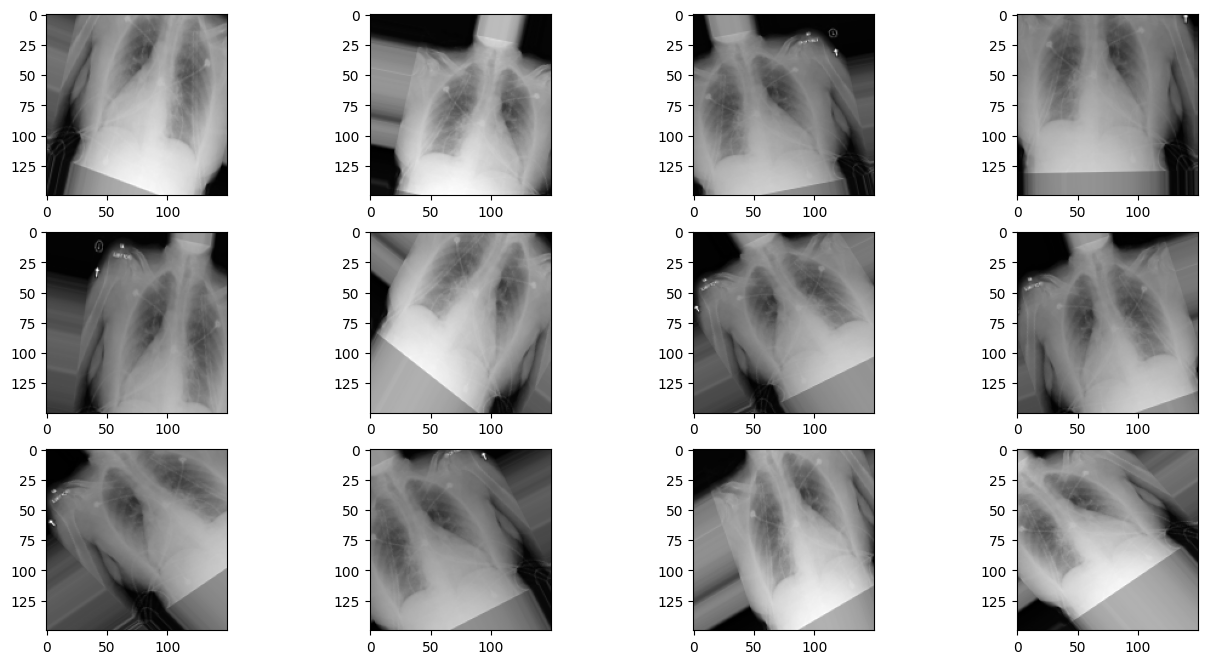

In [50]:
# @title Zbiór treningowy lung_opacity:
idx = 143  # @param {type:'slider', min:0, max:821}
display_augmented_images(train_lung_opacity_dir, idx)

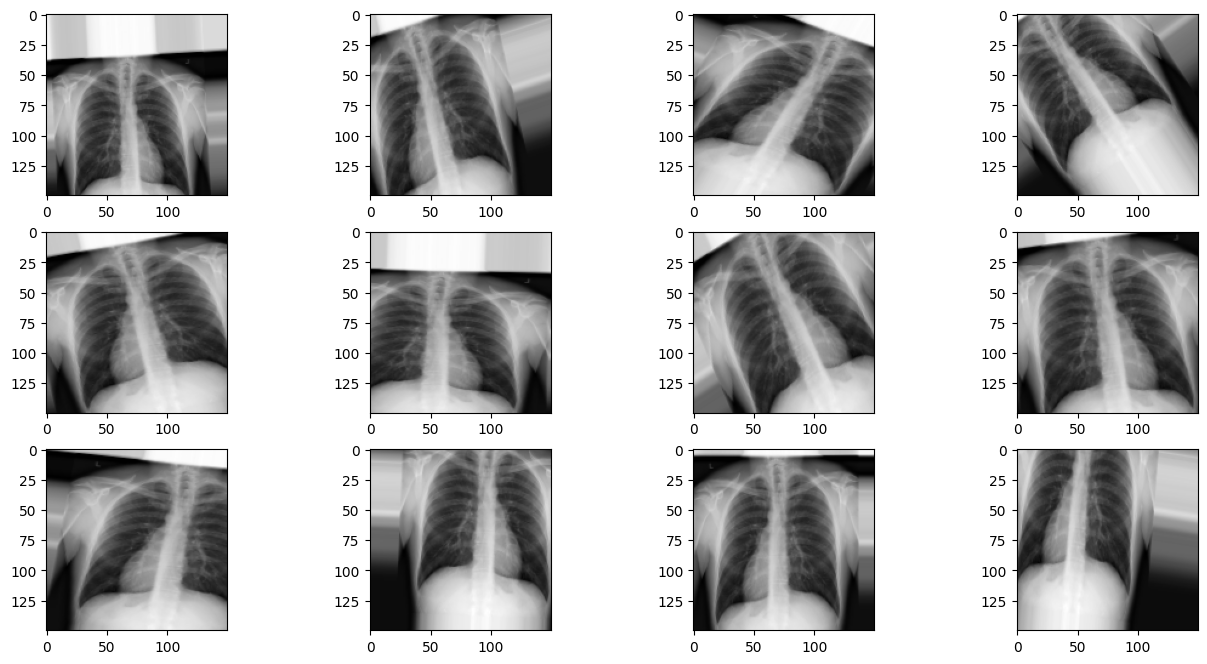

In [51]:
# @title Zbiór treningowy normal:
idx = 0  # @param {type:'slider', min:0, max:821}
display_augmented_images(train_normal_dir, idx)

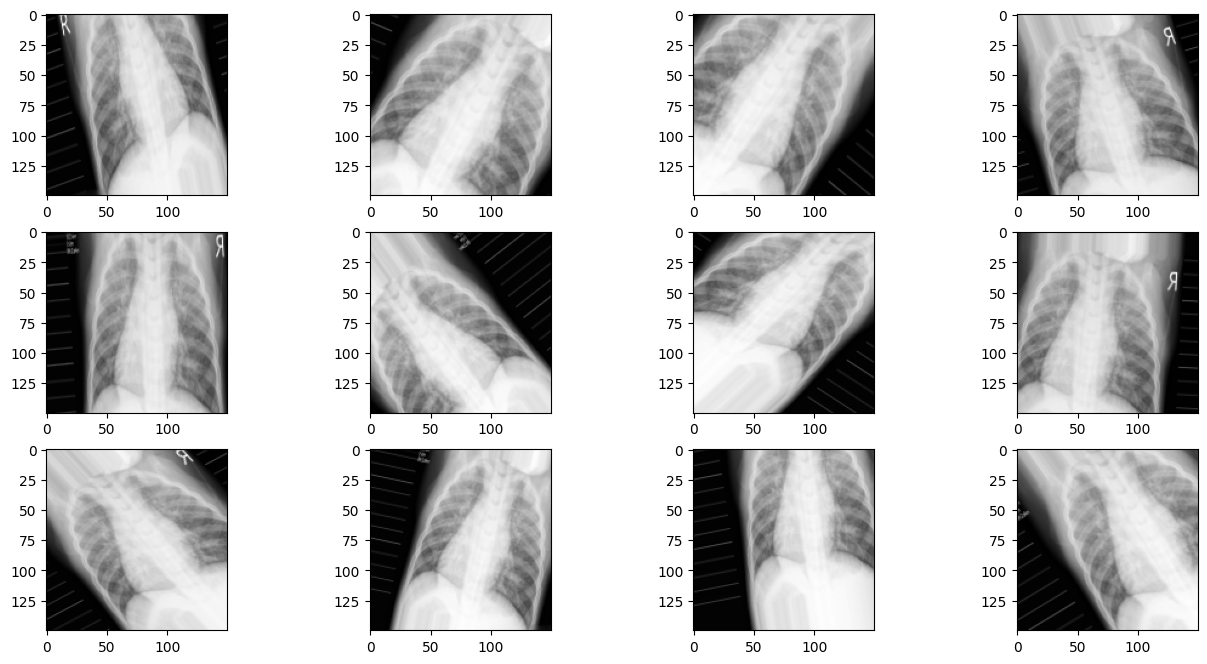

In [52]:
# @title Zbiór treningowy viral_pneumonia:
idx = 64  # @param {type:'slider', min:0, max:821}
display_augmented_images(train_viral_pneumonia_dir, idx)

### Budowa modelu

In [65]:
model = Sequential()
model.add(layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(units=512, activation='relu'))
model.add(layers.Dense(units=4, activation='softmax'))
model.summary()

model.compile(optimizer=optimizers.RMSprop(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 74, 74, 32)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_11 (Conv2D)          (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 17, 17, 128)     

In [66]:
batch_size = 32
steps_per_epoch = train_size // batch_size
validation_steps = valid_size // batch_size

In [67]:
history = model.fit_generator(generator=train_generator,
                             steps_per_epoch=steps_per_epoch,
                             epochs=50,
                             validation_data=valid_generator,
                             validation_steps=validation_steps)

<ipython-input-67-d79f17d2b2bf>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(generator=train_generator,


Epoch 1/50
29/29 [==============================] - 12s 252ms/step - loss: 1.3833 - accuracy: 0.2791 - val_loss: 1.3630 - val_accuracy: 0.2891
Epoch 2/50
29/29 [==============================] - 8s 283ms/step - loss: 1.3430 - accuracy: 0.3653 - val_loss: 1.2704 - val_accuracy: 0.3984
Epoch 3/50
29/29 [==============================] - 9s 296ms/step - loss: 1.2880 - accuracy: 0.3967 - val_loss: 1.1604 - val_accuracy: 0.5469
Epoch 4/50
29/29 [==============================] - 8s 267ms/step - loss: 1.2117 - accuracy: 0.4478 - val_loss: 1.1486 - val_accuracy: 0.4414
Epoch 5/50
29/29 [==============================] - 9s 300ms/step - loss: 1.1855 - accuracy: 0.4795 - val_loss: 1.1283 - val_accuracy: 0.4766
Epoch 6/50
29/29 [==============================] - 8s 282ms/step - loss: 1.1268 - accuracy: 0.5043 - val_loss: 0.9833 - val_accuracy: 0.5977
Epoch 7/50
29/29 [==============================] - 8s 261ms/step - loss: 1.0819 - accuracy: 0.5205 - val_loss: 0.9665 - val_accuracy: 0.5352
Epoch

In [68]:
def plot_hist(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    fig = go.Figure()
    fig.add_trace(go.Scatter(x=hist['epoch'], y=hist['accuracy'], name='accuracy', mode='markers+lines'))
    fig.add_trace(go.Scatter(x=hist['epoch'], y=hist['val_accuracy'], name='val_accuracy', mode='markers+lines'))
    fig.update_layout(width=1000, height=500, title='Accuracy vs. Val Accuracy', xaxis_title='Epoki', yaxis_title='Accuracy', yaxis_type='log')
    fig.show()

    fig = go.Figure()
    fig.add_trace(go.Scatter(x=hist['epoch'], y=hist['loss'], name='loss', mode='markers+lines'))
    fig.add_trace(go.Scatter(x=hist['epoch'], y=hist['val_loss'], name='val_loss', mode='markers+lines'))
    fig.update_layout(width=1000, height=500, title='Loss vs. Val Loss', xaxis_title='Epoki', yaxis_title='Loss', yaxis_type='log')
    fig.show()

plot_hist(history)